This is the first in a series of posts in which I'll be exploring machine learning concepts.  The series is loosely based on the sequence from Andrew Ng's [Introduction to Machine Learning](https://www.coursera.org/learn/machine-learning) course on Coursera, but won't cover every part of the coursework, and may veer into interesting tangents along the way.

In each post that I cover a major machine learning algorithm, I'll first implement it from scratch, using standard Python data science tools like numpy, scikit-learn and others.  Then, I'll build it in [Tensorflow](https://www.tensorflow.org/), a powerful new machine learning library from Google.

The first algorithm is [linear regression](https://en.wikipedia.org/wiki/Linear_regression).  Linear regression attempts to fit a line of best fit to a data set, using one or more features as coefficients for a linear equation.  This algorithm is the most basic in machine learning and should look familiar to anyone who has been exposed to even a little bit of statistics.

# Generating and Plotting Data

I'm using the [`make_regression`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html) function from [scikit-learn](http://scikit-learn.org/stable/index.html) to generate a simple data set that will illustrate this algorithm well. This function takes a number of parameters to tune its output, but here the important ones are the number of samples (100), the number of features (1, allowing a 2D plot of the data and regression), and noise, which adds a little random variation so the points don't lie *exactly* on a line.

In [1]:
from sklearn.datasets import make_regression
import numpy as np

X, y = make_regression(n_samples=100, n_features=1, noise=15.0)

print('X:', X.shape)
print('y:', y.shape)

X: (100, 1)
y: (100,)


The function returns two outputs, each a one-dimensional array.  The first, $\textbf{X}$, is a 100 row, 1 column matrix, representing 100 samples with 1 feature each.  The second, $\textbf{y}$, is a 100 element vector holding the output values for each sample.

Below I plot the data, after defining a simple plotting function to reuse.

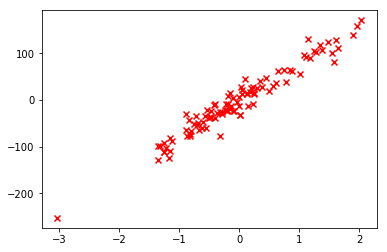

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(X, y):
    plt.scatter(X, y, marker='x', color='red')
    
plot(X, y)

As expected, there's an obvious linear relationship between the x and y points.

# Simple Linear Regression

I only need two simple equations to begin working:  a prediction (or hypothesis) function, and a cost function.  The prediction function takes as inputs an $m \times n$ matrix of features, and an $n$-length vector of parameters, and produces a set of proposed ouputs.  As linear regression fits a straight line equation to the data set, the prediction function looks a lot like the classic equation for a line, $y = mx + b$.

\begin{align}
\hat{y} & = \textbf{X}\textbf{w} \\
\end{align}

By representing $mx + b$ as a single matrix $\times$ vector multiplication $\textbf{X}\textbf{w}$, this now works with any number of input examples (not just a single $x$ point).  It also is generalizable to any number of features, meaning that the same function that's first going to produce a line in 2-dimensional space can be directly applied to a data set with 3 or more dimensions.  

In $y = mx + b$, $b$ is the y-intercept, or the value produced when $x$ is 0.  $b$ can also be thought of as a *bias* term, a flat adjustment to the output of the model, regardless of input.  Instead of representing $b$ separately, I'll take advantage of this function working with multiple dimensions by prepending a columns of 1s to the input matrix $\textbf{X}$, producing a bias term that operates independently of input.  It's perfectly viable to have an explicit $b$ (or bias) term and avoid adjusting the input features in this way, and in fact at the very end I write this algorithm in Tensorflow doing just that.

The [cost function](https://en.wikipedia.org/wiki/Loss_function) calculates the overall error, or difference, between what the model thinks the output should be given weights $\textbf{X}$, and what the actual values are.  There are many cost functions, but here I'm using [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error), or MSE.  MSE is simply adding up the square of the difference between $\hat{y}$ and actual $y$ for every input (squaring ensures a positive value is always produced, and penalizes large errors over small ones), and then produces a mean by diving that by the total number of inputs $m$.

\begin{align}
MSE & = \frac{1}{m}\sum\limits_{i = 1}^{m}(\hat{y}_i - y_i)^2
\end{align}

In [3]:
import numpy as np

def predict(X, w):
    return np.matmul(X, w)

def cost(X, y, w):
    predicted = predict(X, w)
    return np.sum(np.square(predicted - y)) / len(y)

All that remains is to go from some initial $\textbf{w}$ to one that produces the lowest possible value for $MSE$.  This is done using [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent), an algorithm that approaches this final $\textbf{w}$ iteratively.  Gradient descent uses the derivative of the cost function to find a $\nabla w$ by which $\textbf{w}$ is updated each iteration.  In this 1-dimensional case here, this isn't the derivative with respect to $\textbf{X}$ (or $x$, in $y = mx + b$), but with respect to $\textbf{w}$ (both $m$ and $b$).  See [here](http://mccormickml.com/2014/03/04/gradient-descent-derivation/) for a more detailed explanation of how the delta term is derived.

$\nabla w$ is moderated by a learning rate parameter $\alpha$, which ensures that the iterations are sufficiently small and the adjustments don't cause gradient descent to hop past the bottom of the curve.  An $\alpha$ value that is too high can mean the algorithm might never near at the minimum value of $\textbf{w}$, but properly tuned, gradient descent is guaranteed to approach it.

\begin{align}
\nabla w & = \frac{1}{m} \sum_{i=1}^m (\hat{y}_i - y_i)\  \textbf{x}_i \\
\textbf{w} & := \textbf{w} - \alpha\nabla w \\
\end{align}

Below, the implementation performs the updates and also keeps track of the cost each iteration so the convergence can be plotted later.  Immediately before calling it, I prepend a column of 1s to the input features to allow for a bias term.

In [4]:
def gradient_descent(X, y, rate, iterations):
    weights = np.zeros(X.shape[1])
    costs = []
    
    for i in range(iterations):
        costs.append(cost(X, y, weights))
        
        error = predict(X, weights) - y
        weights = weights - (rate / len(y)) * np.dot(X.T, error)

    return weights, costs

X_ = np.hstack((np.ones((100, 1)), X))
w, costs = gradient_descent(X_, y, 0.1, 100)

print("weights:", w)
print('cost:', cost(X_, y, w))

weights: [ -0.49814395  78.72331739]
cost: 265.013731626


When plotted as $y = mx + b$, the weights give us a line that looks like the best possible fit.

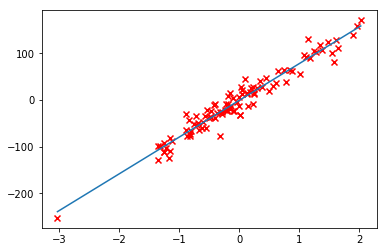

In [5]:
plot(X, y)
points = np.linspace(min(X), max(X))
plt.plot(points, w[0] + w[1] * points)

Using the list of costs, I can plot the convergence of the algorithm.  The cost is seen diminishing rapidly in the first 20 or so iterations, and then the curve flattens.  Even after 100 iterations, it's still diminishing, albeit very slowly.  Eventually, some limit of practical or numerical precision is reached, and there's no point in minimizing further.

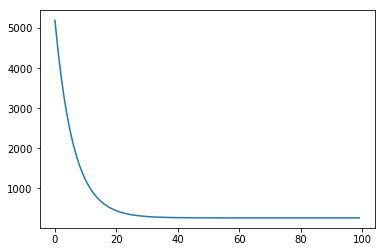

In [6]:
plt.plot(costs)

A much more interesting way of looking at how gradient descent works is to plot the cost function in 3 dimensions, with the $\textbf{w}_0$ and $\textbf{w}_1$ as inputs and the cost as output.  Doing this with `matplotlib` involves generating a 2d mesh of inputs for $\textbf{w}_0$ and $\textbf{w}_1$ in some range of space, calculating the cost for each pair, and then plotting the result.

The very lowest point on the plot, where a ball would eventually settle if allowed to roll down the slope, is the value for $\textbf{w}$ that minimizes the cost function.

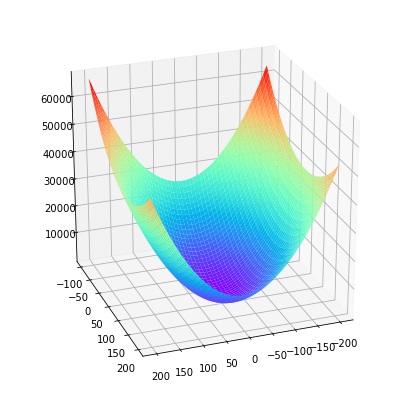

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

Xs, Ys = np.meshgrid(np.linspace(-200, 200, 50), np.linspace(-100, 200, 50))
Zs = np.array([cost(X_, y, w) for w in zip(np.ravel(Xs), np.ravel(Ys))])
Zs = np.reshape(Zs, Xs.shape)

fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection="3d")

ax.view_init(elev=25, azim=70)
ax.plot_surface(Xs, Ys, Zs, cmap=cm.rainbow)

A different way to look at this is a countour plot, which gives a top-down perspective on the above function similar to how a map might show elevation by drawing lines where the ground rises past discrete heights above sea level.  The value for $\textbf{w}$ found using gradient descent sits right in the middle of the lowest elevation.

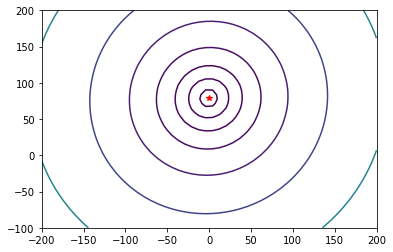

In [8]:
ax = plt.figure().gca()
ax.plot(w[0], w[1], 'r*')
plt.contour(Xs, Ys, Zs, np.logspace(-5, 5, 30))

# Multiple Linear Regression

Because the above implementation works for any number of dimensions, it's possible to generate a higher-dimensional data set and apply it without modification.  Here, I use `make_regression` as before, but specify 5 features instead of one.

In [9]:
X, y = make_regression(n_samples=100, n_features=5, noise=15.0)
X_ = np.hstack((np.ones((100, 1)), X))
w, _ = gradient_descent(X_, y, 0.1, 100)

print("weights:", w)
print('cost:', cost(X_, y, w))

weights: [   1.24705831  100.96575591   23.132232     89.11003594    7.89103108
   69.8366268 ]
cost: 242.78868509


Unfortunately, I can't visually examine the results in 5 dimensions.  However, there's an entirely different way of minimizing $MSE$ in linear regression that I can use to check the results. The [normal equation](http://eli.thegreenplace.net/2014/derivation-of-the-normal-equation-for-linear-regression/) solves directly for the solution without iteration, although it begins to perform worse than gradient descent with large (10,000+) numbers of features.

$$
\theta = (X^TX)^{-1}X^Ty
$$

In [10]:
from numpy.linalg import inv

def normal_eq(X, y):
    return inv(X.T.dot(X)).dot(X.T).dot(y)

w = normal_eq(X_, y)

print('weights:', w)
print('cost:', cost(X_, y, w))

weights: [   1.277097    101.0321116    23.15305289   89.16306293    7.90673083
   69.83354026]
cost: 242.782581366


The values are close enough to prove that the gradient descent implementation works for $n$-dimensional data, but it's not exactly the same: the results of the normal equation represent the *exact* values for $\textbf{w}$ that gradient descent would find if allowed to continue iterating longer, factoring in the limits of numerical precision.

## Linear Regression in Tensorflow

[Tensorflow](https://www.tensorflow.org/) is an open-source machine learning library from Google.  While it's remarkable just how little code is required to set up and run a linear regression, what really impressed me is that I was able to entirely skip some of the math — by defining the cost function as a computational graph, Tensorflow is able to minimize the cost function directly by doing the calculus itself.

I start by defining placeholders for values which will be fed to the graph at execution time ($\textbf{X}$ and $\textbf{y}$) and variables for `weights` and `bias`, which Tensorflow's optimizer will solve for.  I also explicitly reshape the $\textbf{y}$ input into an $m \times 1$ matrix.  Unlike numpy, which automatically promotes a 1-dimensional vector of length $m$ to an $m \times 1$ column vector when doing matrix multiplication, Tensorflow requires it to be shaped explicitly.

In [11]:
import tensorflow as tf

y = y.reshape((-1, 1))
m = X.shape[0]
n = X.shape[1]

examples = tf.placeholder(tf.float32, [m,n])
labels = tf.placeholder(tf.float32, [m,1])
weights = tf.Variable(tf.zeros([n,1], dtype=np.float32), name='weight')
bias = tf.Variable(tf.zeros([1], dtype=np.float32), name='bias')

Only three lines of code are needed to implement the algorithm — define a prediction function, a cost function, and then create an optimizer to minimize the cost.

In [12]:
predict = tf.add(tf.matmul(examples, weights), bias)
cost = tf.reduce_sum(tf.square(predict - y)) / m
optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(cost)

The graph is now ready to use.  I open a Tensorflow [session](https://www.tensorflow.org/api_docs/python/tf/Session), which serves as workspace in which variables are optimized and can then be used, run the optimizer, and print the resulting weights and bias:

In [13]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for i in range(1, 100):
        sess.run(optimizer, feed_dict={
            examples: X,
            labels: y
        }) 
        
    print('weights:', sess.run(weights))
    print('bias:', sess.run(bias))

weights: [[ 101.0320816 ]
 [  23.15303993]
 [  89.16304016]
 [   7.90672207]
 [  69.83355713]]
bias: [ 1.27708232]


These values match what both my iterative gradient descent and normal equation algorithms produced, so I have a high degree of confidence that I've done it correctly here.

You can find the IPython notebook for this post on [GitHub](https://github.com/crsmithdev/notebooks/blob/master/ml-linear-regression/ml-linear-regression.ipynb).